In [ ]:
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
indk214_brain_tumor_dataset_segmentation_and_classification_path = kagglehub.dataset_download('indk214/brain-tumor-dataset-segmentation-and-classification')

print('Data source import complete.')


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Using Colab cache for faster access to the 'brain-tumor-dataset-segmentation-and-classification' dataset.
Data source import complete.


In [ ]:
import os, hashlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, f1_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

class Config:
    EPOCHS = 30
    IMG_SIZE = 224
    BATCH_SIZE = 16
    SEED = 42
    LR = 1e-4
    VALIDATION_SPLIT = 0.2
    TEST_SPLIT = 0.1
    PATIENCE = 5
    FACTOR = 0.5
    MIN_LR = 1e-7


# **Data preparation**





In [ ]:
LABEL_MAP = {
    "glioma": "glioma",
    "meningioma": "meningioma",
    "pituitary": "pituitary",
    "pituitary tumor": "pituitary",
    "notumor": "no_tumor",
    "no_tumor": "no_tumor"
}

def file_hash(filepath):
    """Calculates the MD5 hash of a file."""
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def create_df_from_paths(paths, remove_duplicates=True):
    data = {"images": [], "labels": [], "hash": []}

    for dataset_path in paths:
        for root, dirs, files in os.walk(dataset_path):
            label_name = os.path.basename(root).lower()
            if label_name in LABEL_MAP:
                final_label = LABEL_MAP[label_name]
                for f in files:
                    if f.lower().endswith((".jpg", ".jpeg", ".png")):
                        file_path = os.path.join(root, f)
                        file_md5 = file_hash(file_path)
                        data["images"].append(file_path)
                        data["labels"].append(final_label)
                        data["hash"].append(file_md5)

    df = pd.DataFrame(data)

    if remove_duplicates:
        df = df.drop_duplicates(subset="hash").reset_index(drop=True)

    return df


paths = [
    os.path.join(indk214_brain_tumor_dataset_segmentation_and_classification_path, "classification", "Training"),
    os.path.join(indk214_brain_tumor_dataset_segmentation_and_classification_path, "classification", "Testing"),

    os.path.join(masoudnickparvar_brain_tumor_mri_dataset_path, "Training"),
    os.path.join(masoudnickparvar_brain_tumor_mri_dataset_path, "Testing")
]

df = create_df_from_paths(paths, remove_duplicates=True)

print(" Final dataset shape:", df.shape)
print("Class distribution:\n", df['labels'].value_counts())

 Final dataset shape: (6726, 3)
Class distribution:
 labels
pituitary     1740
no_tumor      1731
meningioma    1635
glioma        1620
Name: count, dtype: int64


In [ ]:
print("Dataset shape:", df.shape)
print("\n Number of images per class:")
print(df['labels'].value_counts())

Dataset shape: (6726, 3)

 Number of images per class:
labels
pituitary     1740
no_tumor      1731
meningioma    1635
glioma        1620
Name: count, dtype: int64


/tmp/ipython-input-3831694968.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, palette="Set2")


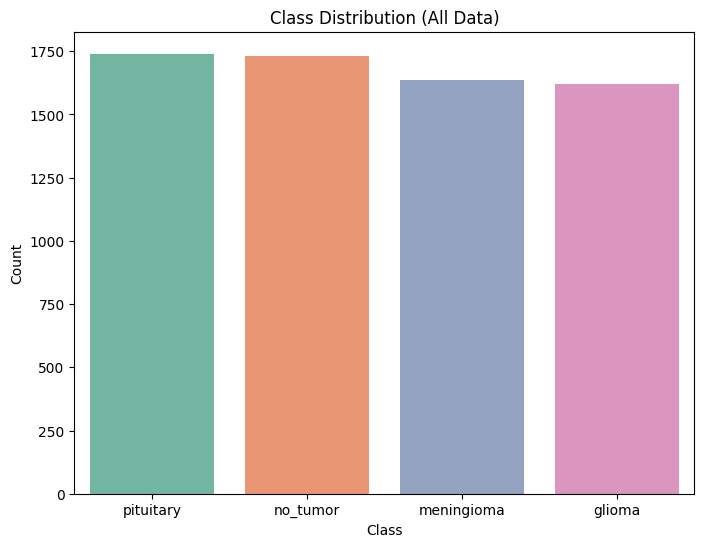

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='labels', order=df['labels'].value_counts().index, palette="Set2")
plt.title("Class Distribution (All Data)")
plt.xlabel("Class"); plt.ylabel("Count")
plt.show()

# **Preprocessing**

In [ ]:
def preprocess_image(image_path, img_size=Config.IMG_SIZE):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = tf.cast(image, tf.float32) / 255.0
    return image

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    return image, label

def create_dataset(df, batch_size=Config.BATCH_SIZE, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((df['images'].values, df['labels'].values))

    def load_and_preprocess_image(path, label):
        return preprocess_image(path), label

    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=Config.SEED)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Encode labels
unique_labels = df["labels"].unique()
label_index = {label: i for i, label in enumerate(unique_labels)}
df["labels"] = df["labels"].map(label_index)

num_classes = len(unique_labels)
class_names = list(unique_labels)

# Train / Val / Test split
train_val_df, test_df = train_test_split(df, test_size=Config.TEST_SPLIT,
                                         stratify=df['labels'], random_state=Config.SEED)
train_df, val_df = train_test_split(train_val_df,
                                    test_size=Config.VALIDATION_SPLIT/(1-Config.TEST_SPLIT),
                                    stratify=train_val_df['labels'], random_state=Config.SEED)

train_dataset = create_dataset(train_df, augment=True)
val_dataset = create_dataset(val_df, shuffle=False)
test_dataset = create_dataset(test_df, shuffle=False)


# **Model building**

In [ ]:
def build_vgg19(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = True
    for layer in base_model.layers[:15]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = build_vgg19((Config.IMG_SIZE, Config.IMG_SIZE, 3), num_classes)
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,157,764 (76.90 MB)

 Trainable params: 11,931,908 (45.52 MB)

 Non-trainable params: 8,225,856 (31.38 MB)

# **Model training**




In [ ]:
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(train_df['labels']),
                                     y=train_df['labels'])
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

model.compile(
    optimizer=Adam(learning_rate=Config.LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=Config.PATIENCE, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=Config.FACTOR, patience=3, min_lr=Config.MIN_LR, verbose=1),
    ModelCheckpoint("best_vgg19.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=Config.EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6294 - loss: 0.9697
Epoch 1: val_accuracy improved from -inf to 0.78009, saving model to best_vgg19.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 84s 228ms/step - accuracy: 0.6298 - loss: 0.9687 - val_accuracy: 0.7801 - val_loss: 0.5574 - learning_rate: 1.0000e-04
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8580 - loss: 0.4076
Epoch 2: val_accuracy improved from 0.78009 to 0.89450, saving model to best_vgg19.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 65s 214ms/step - accuracy: 0.8581 - loss: 0.4075 - val_accuracy: 0.8945 - val_loss: 0.3423 - learning_rate: 1.0000e-04
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9158 - loss: 0.2597
Epoch 3: val_accuracy improved from 0.89450 to 0.91605, saving model to best_vgg19.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - accuracy: 0.9158 - loss: 0.2596 - val_accuracy: 0.9160 - val_loss: 0.2465 - learning_rate: 1.0000e-04
Epoch 4/30
295/295 ━━━━━━━━━

# **Model evaluation**

In [ ]:
pred_probs = model.predict(test_dataset)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_df['labels'].values

# Accuracy + Report
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=[str(name) for name in class_names]))

43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step
Accuracy: 0.9821693907875185

Classification Report:
               precision    recall  f1-score   support

   pituitary       0.99      0.99      0.99       174
    no_tumor       0.98      0.98      0.98       173
  meningioma       0.97      0.98      0.98       164
      glioma       0.99      0.98      0.98       162

    accuracy                           0.98       673
   macro avg       0.98      0.98      0.98       673
weighted avg       0.98      0.98      0.98       673



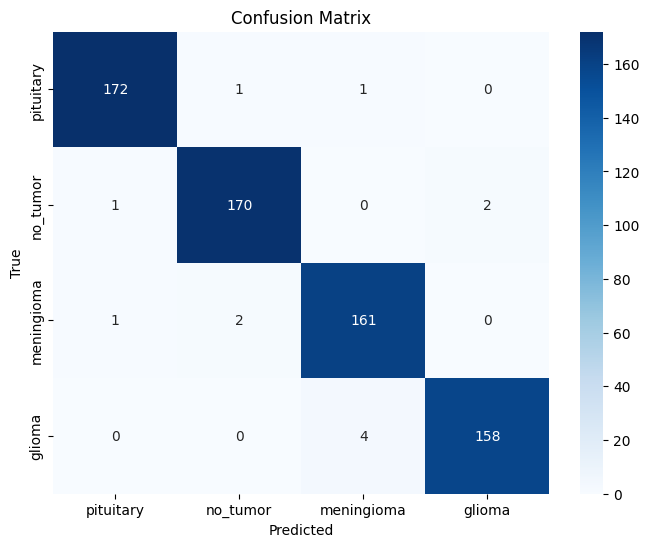

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

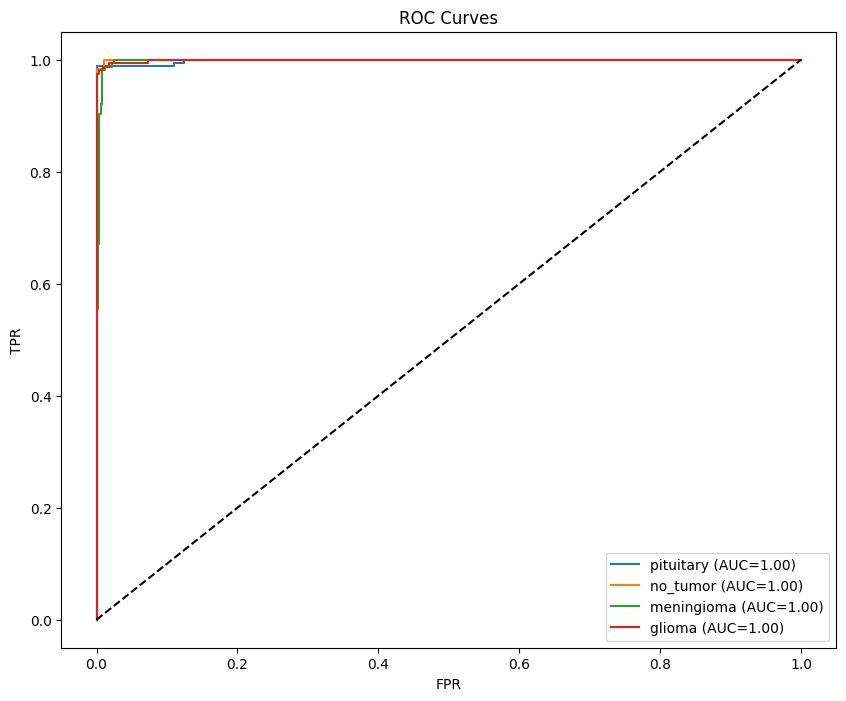

In [ ]:
y_true_bin = label_binarize(y_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.show()

In [ ]:
# F1 scores
f1s = f1_score(y_true, y_pred, average=None)
for i, cls in enumerate(class_names):
    print(f"F1-score {cls}: {f1s[i]:.4f}")
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted'))

F1-score pituitary: 0.9885
F1-score no_tumor: 0.9827
F1-score meningioma: 0.9758
F1-score glioma: 0.9814
Macro F1: 0.9820721855122284
Weighted F1: 0.9821777249388852


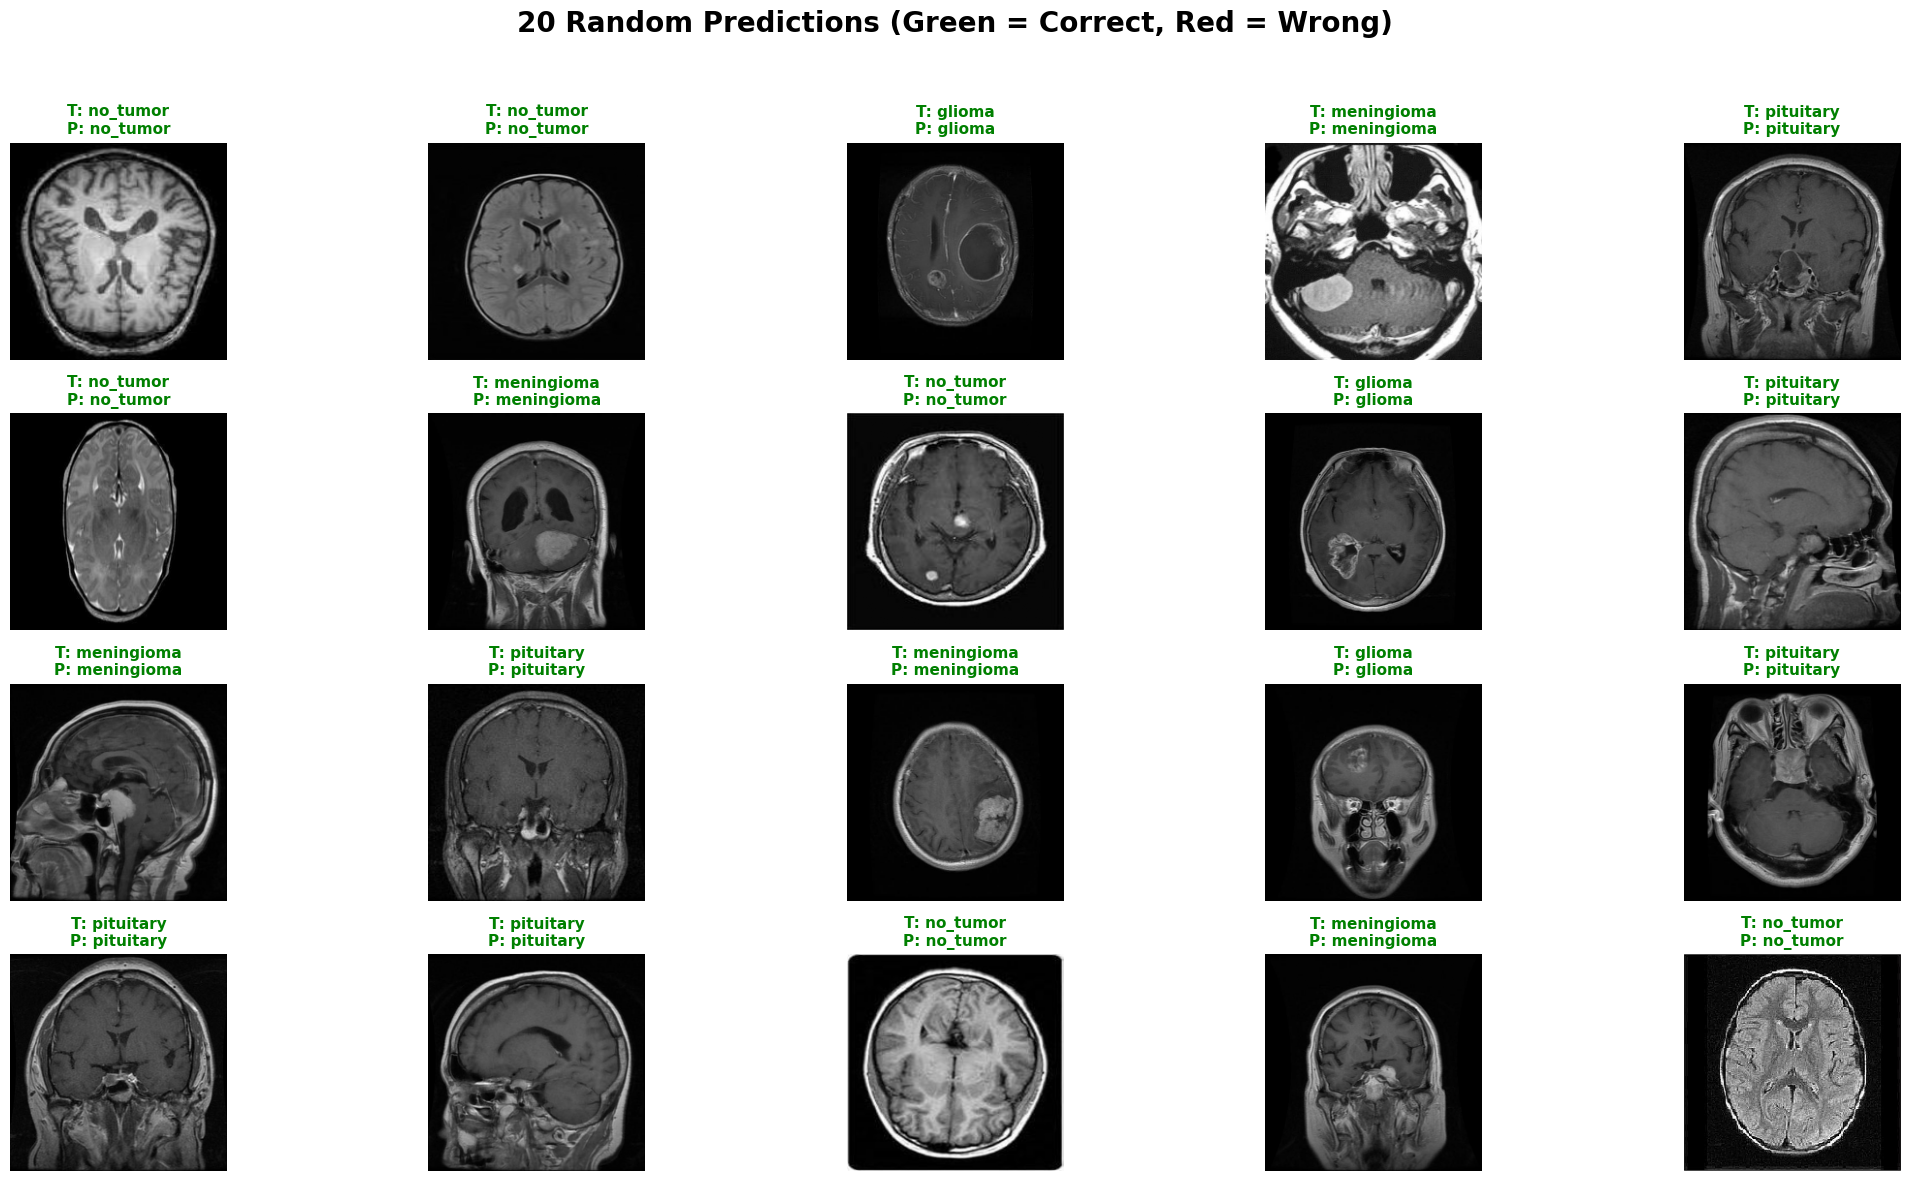

In [ ]:
sample_idx = np.random.choice(len(test_df), size=20, replace=False)

fig, axes = plt.subplots(4, 5, figsize=(22, 12))
fig.suptitle("20 Random Predictions (Green = Correct, Red = Wrong)", fontsize=20, weight="bold")

for ax, idx in zip(axes.ravel(), sample_idx):
    img = preprocess_image(test_df.iloc[idx]['images']).numpy()
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]

    ax.imshow(img)
    ax.axis("off")

    if true_label == pred_label:
        title_color = "green"
    else:
        title_color = "red"

    ax.set_title(f"T: {true_label}\nP: {pred_label}",
                 color=title_color,
                 fontsize=11,
                 fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
